In [117]:
from import_hosp_data import import_data
from cleaning_data import add_cols_remove_rows
from icd9_consolidation import consolidate_icd9_codes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing & Merging Datasets

In [2]:
raw_data = import_data()

admissions_data.csv was imported
patient_data.csv was imported
diagnoses_icd_data.csv was imported
services_data.csv was imported
All files were merged.
Appropriate columns were selected.
Files imported.
Columns selected.


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853417 entries, 0 to 853416
Data columns (total 15 columns):
subject_id            853417 non-null int64
hadm_id               853417 non-null int64
admittime             853417 non-null object
dischtime             853417 non-null object
admission_type        853417 non-null object
admission_location    853417 non-null object
insurance             853417 non-null object
religion              849603 non-null object
marital_status        778505 non-null object
ethnicity             853417 non-null object
gender                853417 non-null object
dob                   853417 non-null object
deathtime             112306 non-null object
icd9_code             853370 non-null object
curr_service          853105 non-null object
dtypes: int64(2), object(13)
memory usage: 104.2+ MB


In [4]:
#DO NOT TOUCH: In case of data destruction
reserve = raw_data.copy()

In [126]:
raw_data.icd9_code.nunique()

6984

# Cleaning Data

9.5% of data was null and was removed

In [118]:
cleaned_data = add_cols_remove_rows(raw_data)

Length of stay column was added.
Age column was added.
DOB column was dropped
Patients who died in the hospital were removed.
Data isolated to first time visits only
Null values dropped.


# Consolidating ICD9_Code Values

In [128]:
cleaned_data.icd9_code.nunique()

838

In [120]:
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.1' if 'V' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.8' if 'M' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.5' if 'E' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: x[:3] if ('E' not in x) & ('M' not in x) & ('V' not in x)else x)

In [121]:
cleaned_data.icd9_code = cleaned_data.icd9_code.astype(float)

In [122]:
cleaned_data.icd9_code.nunique()

838

In [123]:
def f(row):
    if 1 <= row['icd9_code'] <= 139:
        val = 'Parasitic_Disease'
    elif 140 <= row['icd9_code'] <= 239:
        val = 'Neoplasm'
    elif 240 <= row['icd9_code'] <= 279:
        val = 'Endocrine'
    elif 280 <= row['icd9_code'] <= 289:
        val = "Blood"
    elif 290 <= row['icd9_code'] <= 319:
        val = "Mental_Disorder"
    elif 320 <= row['icd9_code'] <= 389:
        val = "Nervous_System"
    elif 390 <= row['icd9_code'] <= 459:
        val = "Circulatory_System"
    elif 460 <= row['icd9_code'] <= 519:
        val = "Respiratory_System"
    elif 520 <= row['icd9_code'] <= 579:
        val = "Digestive_System"
    elif 580 <= row['icd9_code'] <= 629:
        val = "Genitourinary_System"
    elif 630 <= row['icd9_code'] <= 679:
        val = "Pregnancy"
    elif 680 <= row['icd9_code'] <= 709:
        val = "Skin"
    elif 710 <= row['icd9_code'] <= 739:
        val = "Musculoskeletal"
    elif 740 <= row['icd9_code'] <= 759:
        val = "Congenital_Anomalies"
    elif 760 <= row['icd9_code'] <= 779:
        val = "Perinatal"
    elif 780 <= row['icd9_code'] <= 799:
        val = "Ill-Defined"
    elif 800 <= row['icd9_code'] <= 999:
        val = "Injury/Poison"
    elif row['icd9_code'] < .4:
        val = "Supplemental_factors"
    elif .4 <= row['icd9_code'] < .7:
        val = "External_Cause_Inj_Poison"
    elif .7 <= row['icd9_code'] < .9:
        val = "Morphology_of_Neoplasms"     
    else:
        val = row['icd9_code']
    return val


cleaned_data['diagnoses'] = cleaned_data.apply(f, axis=1)

In [124]:
cleaned_data['diagnoses'].nunique()

19

In [125]:
cleaned_data.diagnoses.unique()

array(['Parasitic_Disease', 'Ill-Defined', 'Genitourinary_System',
       'Circulatory_System', 'Skin', 'Endocrine', 'Digestive_System',
       'Supplemental_factors', 'External_Cause_Inj_Poison',
       'Injury/Poison', 'Blood', 'Neoplasm', 'Respiratory_System',
       'Mental_Disorder', 'Musculoskeletal', 'Congenital_Anomalies',
       'Nervous_System', 'Perinatal', 'Pregnancy'], dtype=object)

# Visualizing The Data

## Length Of Stay

In [13]:
#When looking at LOS, given that there is only one subj_id per patient, max, min, and mean are all equivalent
grp_by_hadm = cleaned_data.groupby('hadm_id').agg(['mean'])
grp_by_hadm.los.describe((.01, .75, .99))

,mean
count,41453.000000
mean,9.969328
std,10.539409
min,-0.450694
1%,0.644806
50%,6.961806
75%,11.884028
99%,51.745167
max,294.660417


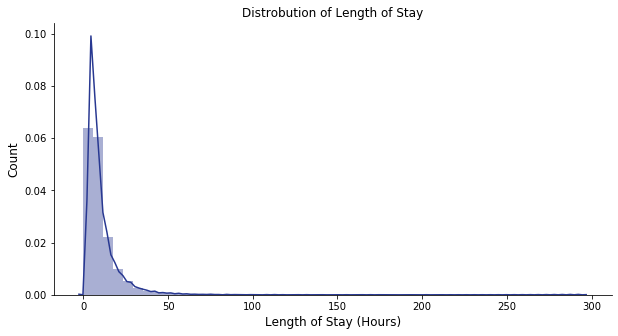

In [14]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(grp_by_hadm.los, color=bidmc_deep_blue)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

In [15]:
eda_data = cleaned_data[cleaned_data.los < cleaned_data.los.quantile(q=.99)]

In [16]:
eda_data = eda_data[eda_data.los > eda_data.los.quantile(q=.01)]

In [17]:
eda_data.los.describe((.01, .75, .99))

count    627394.000000
mean         12.989738
std          11.152509
min           0.984028
1%            1.604167
50%           9.256250
75%          16.489583
99%          56.011806
max          70.406250
Name: los, dtype: float64

In [18]:
grp_by_hadm_id = eda_data.groupby('hadm_id').agg(['mean'])

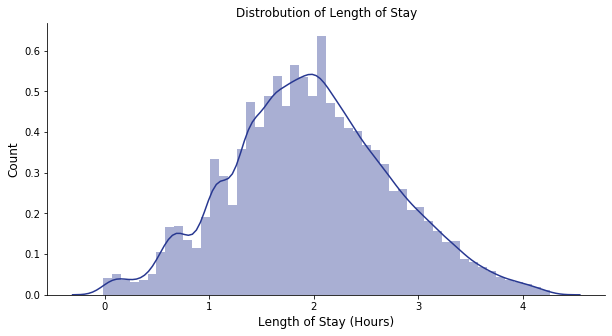

In [130]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(np.log(grp_by_hadm_id.los), color=bidmc_deep_blue)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

holding to remove LOS anamolies

## Correlations

In [20]:
eda_data = eda_data.drop(columns='icd9_code')

In [21]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627394 entries, 3 to 707671
Data columns (total 13 columns):
subject_id            627394 non-null int64
hadm_id               627394 non-null int64
admission_type        627394 non-null object
admission_location    627394 non-null object
insurance             627394 non-null object
religion              627394 non-null object
marital_status        627394 non-null object
ethnicity             627394 non-null object
gender                627394 non-null object
curr_service          627394 non-null object
los                   627394 non-null float64
age                   627394 non-null int64
diagnoses             627394 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 87.0+ MB


### Admission Type

In [22]:
# in order to keep the categorical data, leveraging max 
grped_per_vis = eda_data.groupby('hadm_id').max()

In [23]:
grped_per_vis = grped_per_vis.reset_index()

In [24]:
grped_per_vis.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

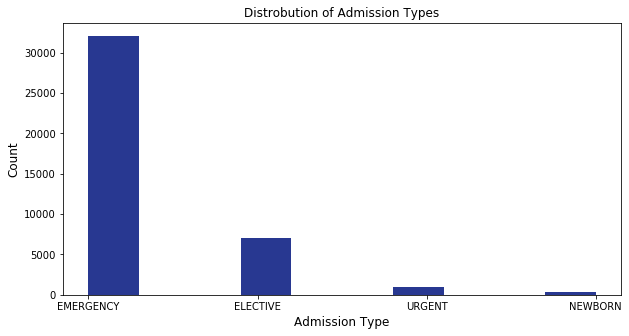

In [25]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.admission_type, color=bidmc_deep_blue)
    
plt.title('Distrobution of Admission Types', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Admission Type', fontsize=12);

In [26]:
grp_adm_type = grped_per_vis.groupby('admission_type')['los'].agg(['mean']).reset_index()
grp_adm_type = grp_adm_type.rename(columns={'mean':'mean_los'})
grp_adm_type

,admission_type,mean_los
0,ELECTIVE,8.532578
1,EMERGENCY,10.070029
2,NEWBORN,7.507905
3,URGENT,12.380599


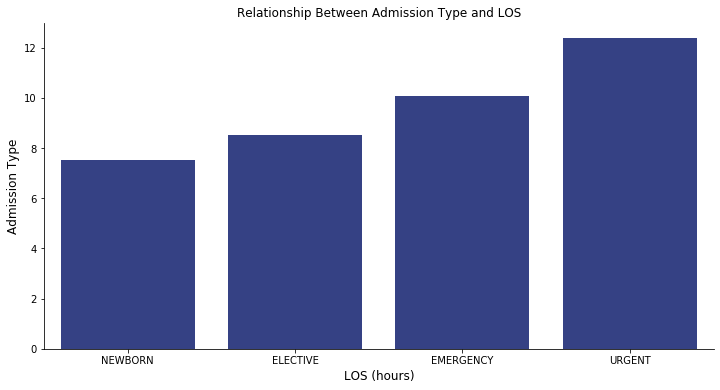

In [27]:
plt.figure(figsize=(12,6))
ethn_los = sns.barplot(y=grp_adm_type.mean_los, x = grp_adm_type.admission_type, color=bidmc_deep_blue, order=['NEWBORN', 'ELECTIVE','EMERGENCY','URGENT']);
    
ethn_los.set_title('Relationship Between Admission Type and LOS', fontsize=12)
ethn_los.set_ylabel('Admission Type', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Admission Location

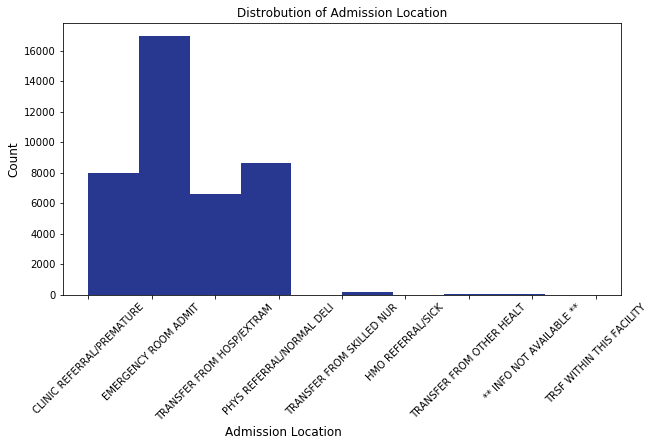

In [28]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.admission_location, color=bidmc_deep_blue)
    
plt.title('Distrobution of Admission Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Admission Location', fontsize=12, ha='right');
plt.xticks(rotation=45);

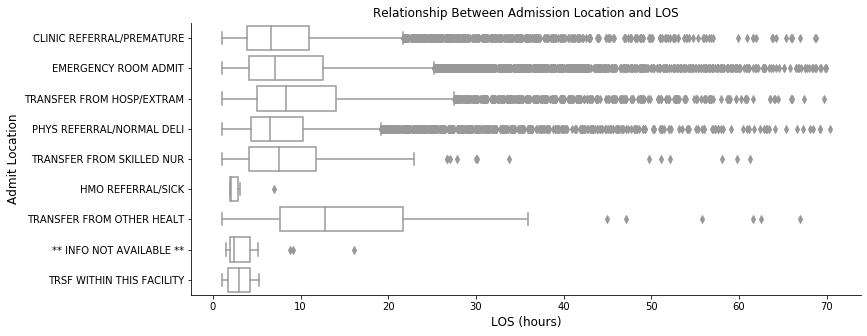

In [29]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.admission_location, color='white');
    
ethn_los.set_title('Relationship Between Admission Location and LOS', fontsize=12)
ethn_los.set_ylabel('Admit Location', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Insurance

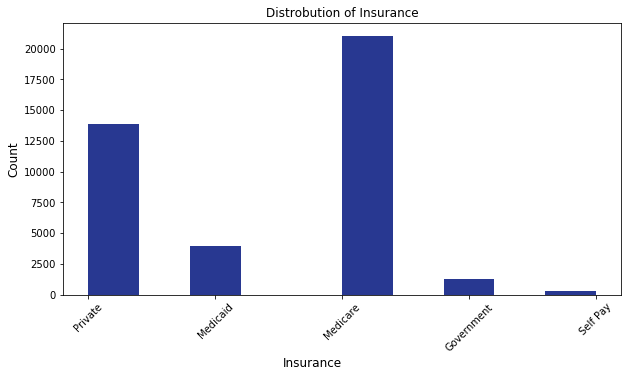

In [30]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
plt.hist(grped_per_vis.insurance, color=bidmc_deep_blue)
    
plt.title('Distrobution of Insurance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Insurance', fontsize=12, ha='right');
plt.xticks(rotation=45);

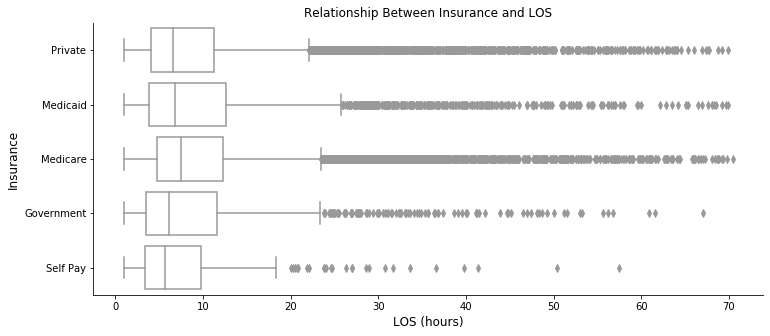

In [31]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.insurance, color='white');
    
ethn_los.set_title('Relationship Between Insurance and LOS', fontsize=12)
ethn_los.set_ylabel('Insurance', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Religion

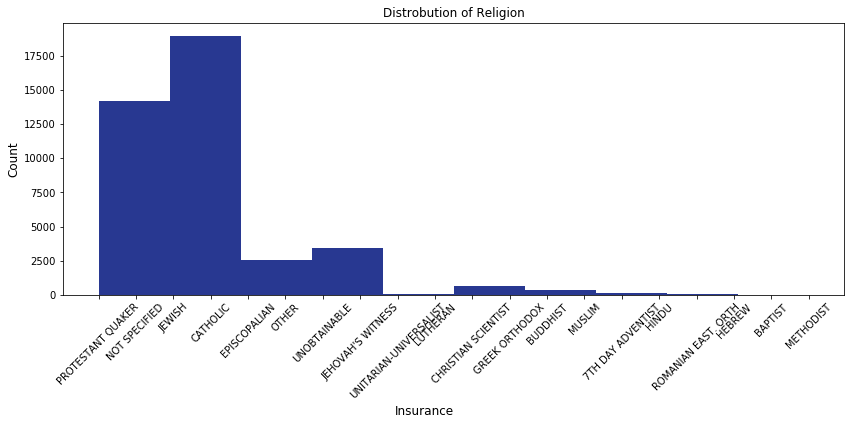

In [32]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.religion, color=bidmc_deep_blue)
    
plt.title('Distrobution of Religion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Insurance', fontsize=12, ha='right');
plt.xticks(rotation=45);

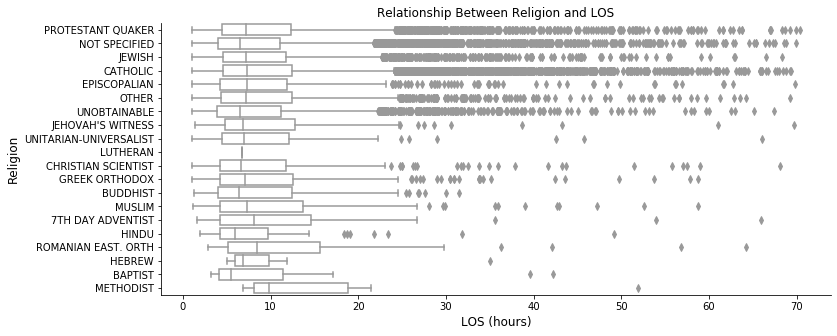

In [33]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.religion, color='white');
    
ethn_los.set_title('Relationship Between Religion and LOS', fontsize=12)
ethn_los.set_ylabel('Religion', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Marital Status

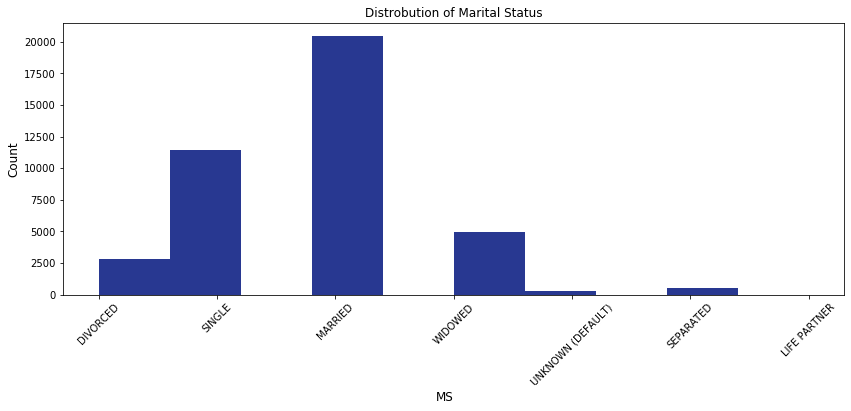

In [34]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.marital_status, color=bidmc_deep_blue)
    
plt.title('Distrobution of Marital Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('MS', fontsize=12, ha='right');
plt.xticks(rotation=45);

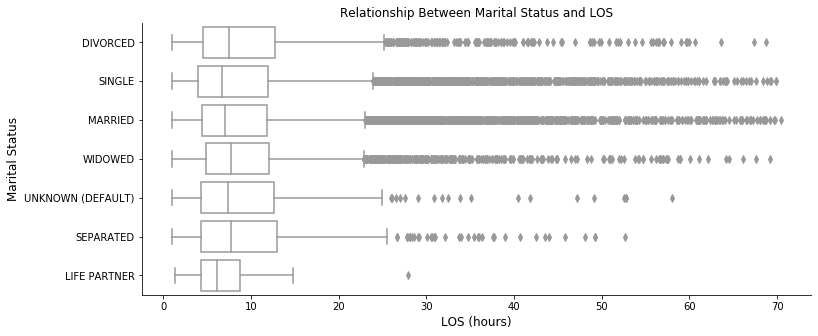

In [35]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.marital_status, color='white');
    
ethn_los.set_title('Relationship Between Marital Status and LOS', fontsize=12)
ethn_los.set_ylabel('Marital Status', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Ethnicity

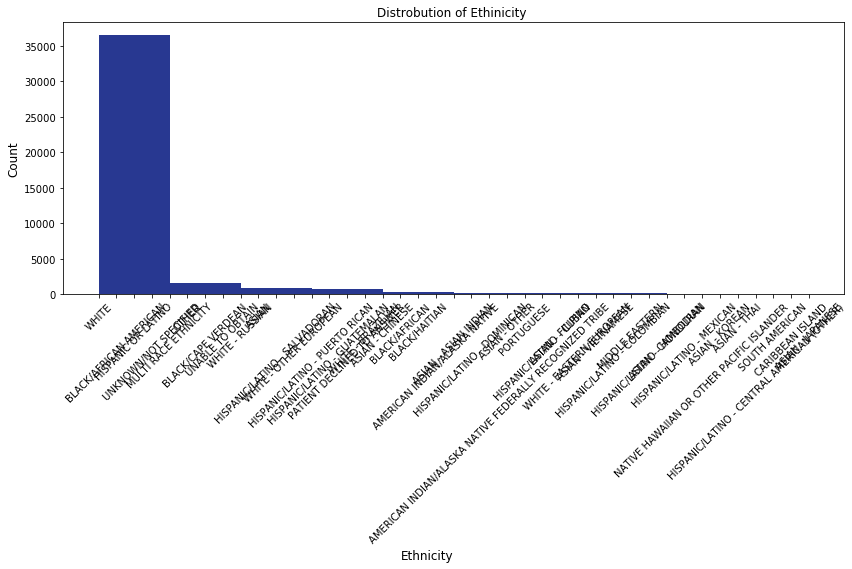

In [36]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.ethnicity, color=bidmc_deep_blue)
    
plt.title('Distrobution of Ethinicity ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ethnicity', fontsize=12, ha='right');
plt.xticks(rotation=45);

### Gender 

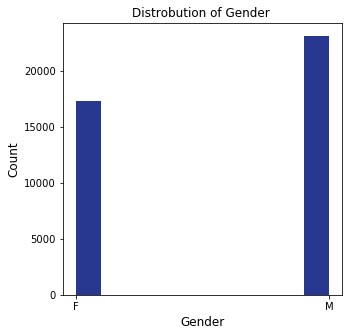

In [37]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(5,5))
plt.hist(grped_per_vis.gender, color=bidmc_deep_blue)
    
plt.title('Distrobution of Gender ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12);

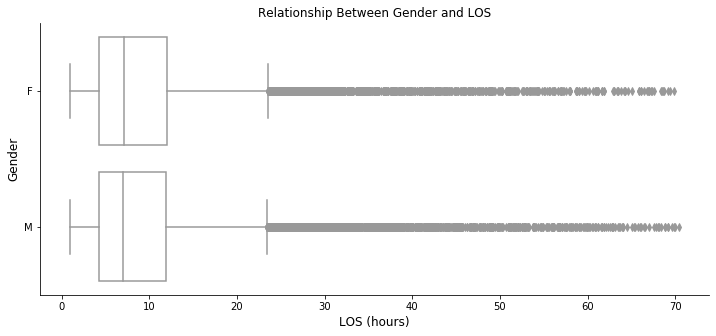

In [38]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.gender, color='white');
    
ethn_los.set_title('Relationship Between Gender and LOS', fontsize=12)
ethn_los.set_ylabel('Gender', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### ICD9 Code

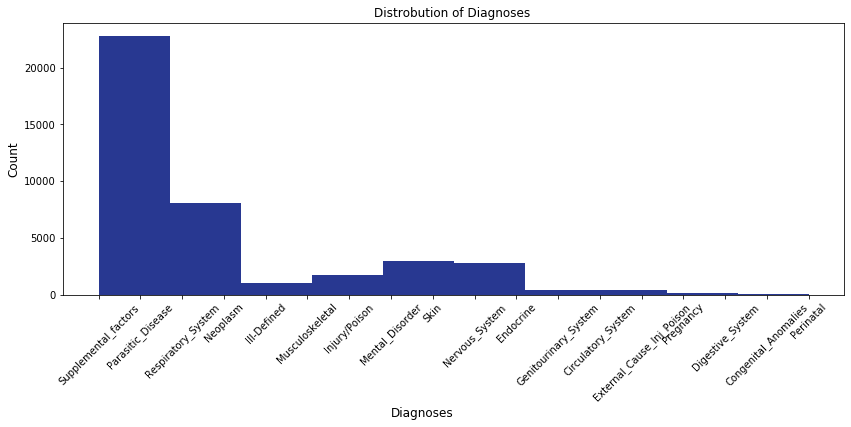

In [39]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.diagnoses, color=bidmc_deep_blue)
    
plt.title('Distrobution of Diagnoses ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Diagnoses', fontsize=12, ha='right');
plt.xticks(rotation=45);

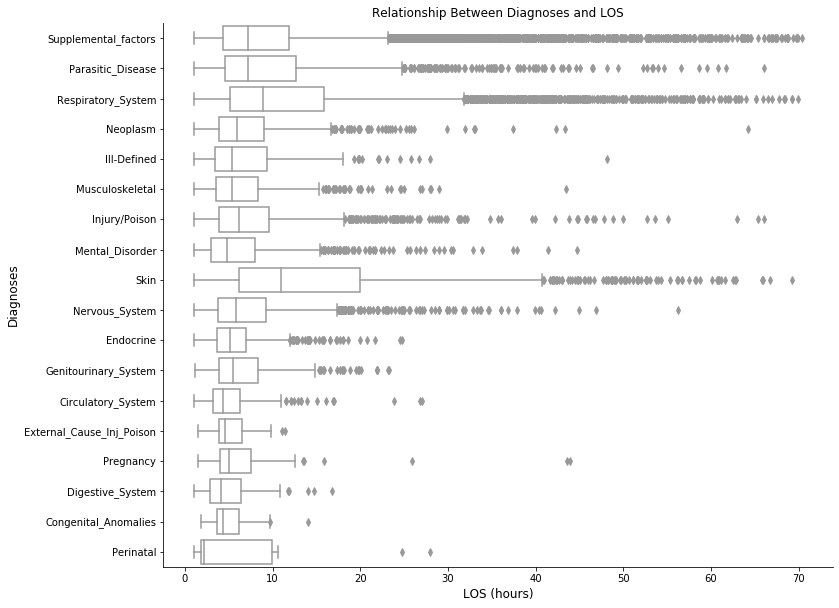

In [40]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.diagnoses, color='white');
    
ethn_los.set_title('Relationship Between Diagnoses and LOS', fontsize=12)
ethn_los.set_ylabel('Diagnoses', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Current Service

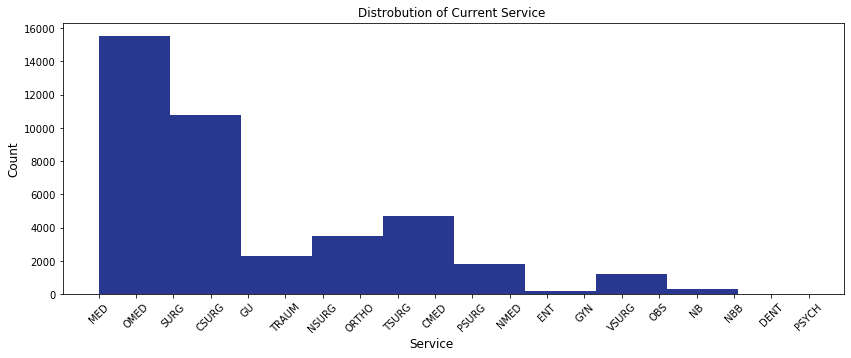

In [41]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.curr_service, color=bidmc_deep_blue)
    
plt.title('Distrobution of Current Service ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Service', fontsize=12, ha='right');
plt.xticks(rotation=45);

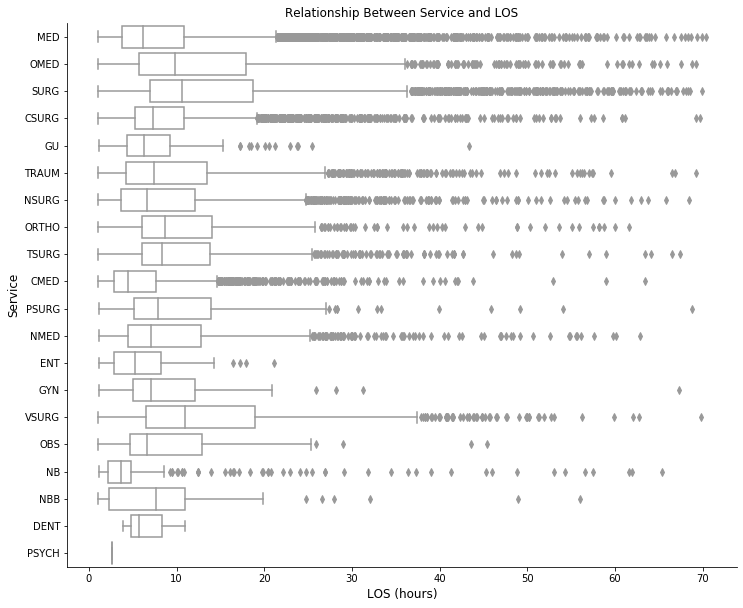

In [42]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=grped_per_vis.los, y = grped_per_vis.curr_service, color='white');
    
ethn_los.set_title('Relationship Between Service and LOS', fontsize=12)
ethn_los.set_ylabel('Service', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

### Age

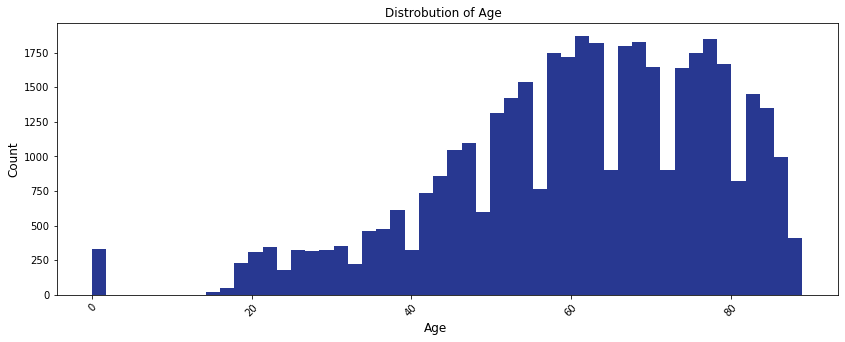

In [93]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(14,5))
plt.hist(grped_per_vis.age, color=bidmc_deep_blue, bins=50)
    
plt.title('Distrobution of Age  ', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12, ha='right');
plt.xticks(rotation=45);

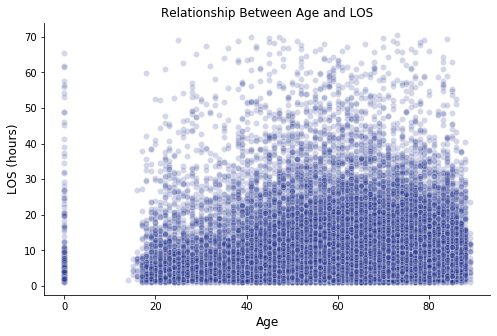

In [94]:
plt.figure(figsize=(8,5))
ethn_los = sns.scatterplot(y=grped_per_vis.los, x = grped_per_vis.age, color=bidmc_deep_blue, alpha=.2);
    
ethn_los.set_title('Relationship Between Age and LOS', fontsize=12)
ethn_los.set_ylabel('LOS (hours)', fontsize=12)
ethn_los.set_xlabel('Age', fontsize=12);
sns.despine()

# Model Development

## Baseline Regression

In [116]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627394 entries, 3 to 707671
Data columns (total 13 columns):
subject_id            627394 non-null int64
hadm_id               627394 non-null int64
admission_type        627394 non-null object
admission_location    627394 non-null object
insurance             627394 non-null object
religion              627394 non-null object
marital_status        627394 non-null object
ethnicity             627394 non-null object
gender                627394 non-null object
curr_service          627394 non-null object
los                   627394 non-null float64
age                   627394 non-null int64
diagnoses             627394 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 87.0+ MB


In [132]:
def dummy_cat_cols(data):
    """Creates dummy variables for each categorical column"""
    cat_cols = ['admission_type', 'admission_location', 'insurance', 'religion ', 'marital_status', 'ethnicity', 'gender', 'curr_service', 'diagnoses']
    dummied_data = pd.get_dummies(data)
    grouped_dummy_data = dummied_data.groupby('hadm_id').max().reset_index()
    select_cols = grouped_dummy_data.drop(columns = ['subject_id', 'hadm_id'])
    print("Other dummy variables created.")
    return select_cols

In [133]:
dummied = dummy_cat_cols(eda_data)

Other dummy variables created.


In [134]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

def splitting_test_and_train(data):
    x_obj_columns = [col for col in data.columns if (data[col].dtype == 'uint8') and (col != 'los')]
    x_fl_columns = [col for col in data.columns if (data[col].dtype == 'float64') and( col != 'los')]
    X_columns = x_fl_columns + x_obj_columns

    X, y = data[X_columns], np.log(data['los'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X_train, y_train = np.array(X_train), np.array(y_train)
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test

def cross_val_testing(X_train, X_test, y_train, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_ridge_r2s, cv_lm_lasso_r2s, cv_lm_elastic_r2s = [], [], [], [] #collect the validation results for both models
    cv_lm_rmse, cv_lm_ridge_rmse, cv_lm_lasso_rmse, cv_lm_elastic_rmse = [], [], [], []
    print("Kfolds created. Running linear, ridge, lasso, and elastic net regressions.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]

        #defining simple linear regression
        lm = LinearRegression()
        lm.fit(X_tr, y_tr)
        lm_predict = lm.predict(X_val)
        cv_lm_r2s.append(lm.score(X_val, y_val))
        cv_lm_rmse.append(np.sqrt(mean_squared_error(y_val, lm_predict)))
        
        #feature scaling for ridge and lasso fits
        #remove when not using numerical age column
        #scaler = StandardScaler()
        #X_tr[:, :1] = scaler.fit_transform(X_tr[:, :1])
        #X_val[:, :1] = scaler.transform(X_val[:, :1])

        #Defining ridge, lasso, elastic net regressions with scaled 'age' column
        lm_ridge = Ridge(alpha=1)
        lm_lasso = Lasso(alpha=1)
        lm_elastic = ElasticNet(alpha=1)

        #ridge regression
        lm_ridge.fit(X_tr, y_tr)
        lm_ridge_predict = lm_ridge.predict(X_val)
        cv_lm_ridge_r2s.append(lm_ridge.score(X_val, y_val))
        cv_lm_ridge_rmse.append(np.sqrt(mean_squared_error(y_val, lm_ridge_predict)))

        #lasso regression
        lm_lasso.fit(X_tr, y_tr)
        lm_lasso_predict = lm_lasso.predict(X_val)
        cv_lm_lasso_r2s.append(lm_lasso.score(X_val, y_val))
        cv_lm_lasso_rmse.append(np.sqrt(mean_squared_error(y_val, lm_lasso_predict)))

        #elastic net regression
        lm_elastic.fit(X_tr, y_tr)
        lm_elastic_predict = lm_elastic.predict(X_val)
        cv_lm_elastic_r2s.append(lm_elastic.score(X_val, y_val))
        cv_lm_elastic_rmse.append(np.sqrt(mean_squared_error(y_val, lm_elastic_predict)))

    print('Simple regression scores r^2: ', cv_lm_r2s)
    print('Ridge scores r^2: ', cv_lm_ridge_r2s, '\n')
    print('Lasso scores r^2: ', cv_lm_lasso_r2s, '\n')
    print('Elastic scores r^2: ', cv_lm_elastic_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
    print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')
    print(f'Elastic mean cv r^2: {np.mean(cv_lm_elastic_r2s):.3f} +- {np.std(cv_lm_elastic_r2s):.3f}\n')

    print('Simple regression scores rmse: ', cv_lm_rmse)
    print('Ridge scores rmse: ', cv_lm_ridge_rmse, '\n')
    print('Lasso scores rmse: ', cv_lm_lasso_rmse, '\n')
    print('Elastic scores rmse: ', cv_lm_elastic_rmse, '\n')

    print(f'Simple mean cv rmse: {np.mean(cv_lm_rmse):.3f} +- {np.std(cv_lm_rmse):.3f}')
    print(f'Ridge mean cv rmse: {np.mean(cv_lm_ridge_rmse):.3f} +- {np.std(cv_lm_ridge_rmse):.3f}')
    print(f'Lasso mean cv rmse: {np.mean(cv_lm_lasso_rmse):.3f} +- {np.std(cv_lm_lasso_rmse):.3f}')
    print(f'Elastic mean cv rmse: {np.mean(cv_lm_elastic_rmse):.3f} +- {np.std(cv_lm_elastic_rmse):.3f}')

    return


In [135]:
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied)

Train and test data are separated


In [136]:
cross_val_testing(X_train, X_test, y_train, y_test)

Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.35420479203270194, -2.442046186222599e+22, -1.5910000629478868e+16, 0.34528570294888916, 0.34481480859087055]
Ridge scores r^2:  [0.3543179851152749, 0.33970759302317444, 0.3462023478779095, 0.3455076862979364, 0.3459547508232476] 

Lasso scores r^2:  [-0.00013618732144471402, -2.0033676150887914e-05, -0.00028581689720885706, -0.0002134735041734448, -0.0005957376433070039] 

Elastic scores r^2:  [-0.00013618732144471402, -2.0033676150887914e-05, -0.00028581689720885706, -0.0002134735041734448, -0.0005957376433070039] 

Simple mean cv r^2: -4884095554445324058624.000 +- 9768183153892276568064.000
Ridge mean cv r^2: 0.346 +- 0.005
Lasso mean cv r^2: -0.000 +- 0.000
Elastic mean cv r^2: -0.000 +- 0.000

Simple regression scores rmse:  [0.619091749757758, 121166523017.49518, 96760408.5217842, 0.62774594972777, 0.6229114203693713]
Ridge scores rmse:  [0.6190374910905572, 0.6300483237

# Feature Engineering

In [51]:
# Admission Type -> urgent to emergency - done
# Current Service -> med, serg, other
# diagnoses -> check if only 1
# ethnicity -> narrow down
# marital status -> narrow down
# insurance -> narrow
# relgiion -> narrow
# admit location -> 'other'

### adm_type

In [115]:
cleaned_data.religion.value_counts()

RELIGIOUS    640215
Name: religion, dtype: int64

In [53]:
def compressing_admission_type(data):
    data.admission_type = data.admission_type.apply(lambda x: 'EMERGENCY' if x == 'URGENT' else x)
    return data

### Age

In [96]:
cleaned_data.age.sort_values()

314553     0
72179      0
72178      0
281986     0
281987     0
          ..
518130    89
518129    89
518128    89
518138    89
343107    89
Name: age, Length: 640215, dtype: int64

In [99]:
def f(row):
    if 0 <= row['age'] <= 3:
        val = 'Baby'
    elif 3 <= row['age'] <= 18:
        val = 'Child/Teen'
    elif 19 <= row['age'] <= 40:
        val = 'Young_Aduld'
    elif 41 <= row['age'] <= 60:
        val = "Adult"
    elif 61 <= row['age'] <= 100:
        val = "Senior"
    return val


def age_to_cat(data):
    data['age'] = data.apply(f, axis=1)
    return data

### curr_serv

In [55]:
cleaned_data.curr_service.value_counts()

MED      263520
CMED      88278
CSURG     74048
SURG      58002
NSURG     28133
OMED      26501
NMED      23005
TRAUM     22812
VSURG     15462
TSURG     13102
ORTHO     12208
GU         4398
GYN        3447
PSURG      2286
ENT        1915
NB         1510
OBS        1269
NBB         278
DENT         37
PSYCH         4
Name: curr_service, dtype: int64

In [56]:
def compressing_curr_serv(data):
    data.curr_service = data.curr_service.apply(lambda x: 'SURGERGY' if (x == 'CSURG') | (x == 'NSURG') | (x == 'ORTHO') | (x == 'PSURG') | (x == 'SURG') | (x == 'TSURG') | (x == 'VSURG') else x)
    data.curr_service = data.curr_service.apply(lambda x: "MED" if (x == 'CMED') | (x == 'OMED') | (x == 'NMED') | (x == 'TRAUM') else x)
    data.curr_service = data.curr_service.apply(lambda x: "GYNOCOLOGY/NEWBORN" if (x == 'NB') | (x == 'NBB') | (x == 'OBS') | (x == 'GYN') else x)
    data.curr_service = data.curr_service.apply(lambda x: "OTHER" if (x == "GU") | (x == "ENT") | (x == "DENT") | (x == "PSYCH") else x)
    return data

### ethnicity

In [59]:
v3.ethnicity.value_counts()

WHITE                                                       466551
BLACK/AFRICAN AMERICAN                                       64482
UNKNOWN/NOT SPECIFIED                                        30302
HISPANIC OR LATINO                                           16832
OTHER                                                        15052
ASIAN                                                         8576
UNABLE TO OBTAIN                                              6884
PATIENT DECLINED TO ANSWER                                    5236
HISPANIC/LATINO - PUERTO RICAN                                3863
ASIAN - CHINESE                                               3287
BLACK/CAPE VERDEAN                                            2529
WHITE - RUSSIAN                                               2013
MULTI RACE ETHNICITY                                          1394
BLACK/HAITIAN                                                 1380
ASIAN - ASIAN INDIAN                                          

In [60]:
def compressing_ethnicity(data):
    data.ethnicity = data.ethnicity.apply(lambda x: 'WHITE' if ("WHITE" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "ASIAN" if ("ASIAN" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "HISPANIC/LATINO" if ("LATINA" in x) | ("HISPANIC" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "OTHER/UNKNOWN" if (x=="AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE") | (x=="SOUTH AMERICAN") | (x=="CARIBBEAN ISLAND") | (x=="NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER") |(x=="AMERICAN INDIAN/ALASKA NATIVE") | (x=="MIDDLE EASTERN") | (x=="PORTUGUESE") | (x=="MULTI RACE ETHNICITY") | (x=="PATIENT DECLINED TO ANSWER") | (x=="OTHER") | ("UNKNOWN" in x) | ("OBTAIN" in x) else x)
    data.ethnicity = data.ethnicity.apply(lambda x: "BLACK_AFRICAN/OTHER" if ("BLACK" in x) else x)
    return data

### marital status

In [63]:
v4.marital_status.value_counts()

MARRIED              320011
SINGLE               176446
WIDOWED               85000
DIVORCED              46772
SEPARATED              8055
UNKNOWN (DEFAULT)      3629
LIFE PARTNER            302
Name: marital_status, dtype: int64

In [64]:
def compressing_marital_status(data):
    data.marital_status = data.marital_status.apply(lambda x: 'LIFE_PARTNER' if (x == 'MARRIED') | (x == 'LIFE PARTNER') else x)
    data.marital_status = data.marital_status.apply(lambda x: 'SINGLE' if (x == 'WIDOWED') | (x == 'DIVORCED') | (x == 'SEPARATED') else x)
    data.marital_status = data.marital_status.apply(lambda x: 'OTHER/UNKNOWN' if (x == 'UNKNOWN (DEFAULT)') else x)
    return data

### insurance

In [67]:
v5.insurance.value_counts()

Medicare      367793
Private       191877
Medicaid       60779
Government     16166
Self Pay        3600
Name: insurance, dtype: int64

### relgiion

In [69]:
def compressing_religion(data):
    data.religion = data.religion.apply(lambda x: 'NOT_SPECIFIED' if (x == 'NOT SPECIFIED') | (x == 'UNOBTAINABLE') else "RELIGIOUS")
    return data

### Admission Location

In [72]:
v6.admission_location.value_counts()

EMERGENCY ROOM ADMIT         258153
CLINIC REFERRAL/PREMATURE    160512
TRANSFER FROM HOSP/EXTRAM    110053
PHYS REFERRAL/NORMAL DELI    107442
TRANSFER FROM SKILLED NUR      2796
TRANSFER FROM OTHER HEALT      1042
** INFO NOT AVAILABLE **        107
TRSF WITHIN THIS FACILITY        87
HMO REFERRAL/SICK                23
Name: admission_location, dtype: int64

In [73]:
def compressing_admit_location(data):
    data.admission_location = data.admission_location.apply(lambda x: 'ER_ADMIT' if (x == 'EMERGENCY ROOM ADMIT ') else x)
    data.admission_location = data.admission_location.apply(lambda x: 'REFERRAL' if (x == 'HMO REFERRAL/SICK') | (x == 'PHYS REFERRAL/NORMAL DELI') | (x == 'CLINIC REFERRAL/PREMATURE') else x)
    data.admission_location = data.admission_location.apply(lambda x: 'TRANSFER' if (x == 'TRANSFER FROM HOSP/EXTRAM') | (x == 'TRANSFER FROM SKILLED NUR') | (x == 'TRANSFER FROM OTHER HEALT') | (x == 'TRSF WITHIN THIS FACILITY')else x)
    data.admission_location = data.admission_location.apply(lambda x: 'OTHER/UNKNOWN' if (x == '** INFO NOT AVAILABLE **')  else x)
    return data

# Model After Engineering (No impact on diagnoses)

In [76]:
dummy_data_v2 = dummy_cat_cols(v7)

Other dummy variables created.


In [77]:
X_train_2, X_test_2, y_train_2, y_test_2 = splitting_test_and_train(dummy_data_v2)
cross_val_testing(X_train_2, X_test_2, y_train_2, y_test_2)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24560370356587924, 0.23816375406752097, 0.24445025807149023, 0.22392567872995417, 0.2509386574656911]
Ridge scores r^2:  [0.24565287054873042, 0.23819455673322554, 0.24444707889130324, 0.22389270649240978, 0.2509481136988748] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.0852013886956452, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.241 +- 0.009
Ridge mean cv r^2: 0.241 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.470713728482608, 8.938633363193851, 8.7820513332586, 9.425872399960193, 9.201690673253266]
Ridge scores rmse:  [9.470405101565344, 8.938452657353224, 8.782069809669007, 9.426072631300357, 9.2016325914

# Feature Engineering Model Dev

## No feature engineering

In [78]:
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.2976146771232215, -2.497647455181509e+21, -4.237520114086929e+17, 0.28271073019238013, 0.28754427579150144]
Ridge scores r^2:  [0.2977671658709381, 0.28441997695859633, 0.29066943461907024, 0.2833454871816484, 0.2891024858707705] 

Lasso scores r^2:  [0.014368338329384223, 0.016234698074030218, 0.015573152385489508, 0.015098522292743666, 0.011849186685114366] 

Elastic scores r^2:  [0.05920284633043127, 0.054425156459291135, 0.05825246030060105, 0.06120643275205184, 0.059351847439559235] 

Simple mean cv r^2: -499614241438583554048.000 +- 999016620352151879680.000
Ridge mean cv r^2: 0.289 +- 0.005
Lasso mean cv r^2: 0.015 +- 0.002
Elastic mean cv r^2: 0.058 +- 0.002

Simple regression scores rmse:  [7.44233307299077, 455236862683.47797, 5683784578.733118, 7.394279481680493, 7.5383419356793]
Ridge scores rmse:  [7.441525159146578, 7.7055023442234

## Consolidated admission type

In [79]:
fe_adm_type = compressing_admission_type(cleaned_data)

In [80]:
fe_adm_type_dummied = dummy_cat_cols(fe_adm_type)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_adm_type_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24560370356587924, 0.23816375406752097, 0.24445025807149023, 0.22392567872995417, 0.2509386574656911]
Ridge scores r^2:  [0.24565287054873042, 0.23819455673322554, 0.24444707889130324, 0.22389270649240978, 0.2509481136988748] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.0852013886956452, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.241 +- 0.009
Ridge mean cv r^2: 0.241 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.470713728482608, 8.938633363193851, 8.7820513332586, 9.425872399960193, 9.201690673253266]
Ridge scores rmse:  [9.470405101565344, 8.938452657353224, 8.782069809669007, 

## Consolidate current service

In [81]:
fe_cs = compressing_curr_serv(cleaned_data)

In [82]:
fe_cs_dummied = dummy_cat_cols(fe_cs)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_cs_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24560370356587924, 0.23816375406752097, 0.24445025807149023, 0.22392567872995417, 0.2509386574656911]
Ridge scores r^2:  [0.24565287054873042, 0.23819455673322554, 0.24444707889130324, 0.22389270649240978, 0.2509481136988748] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.0852013886956452, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.241 +- 0.009
Ridge mean cv r^2: 0.241 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.470713728482608, 8.938633363193851, 8.7820513332586, 9.425872399960193, 9.201690673253266]
Ridge scores rmse:  [9.470405101565344, 8.938452657353224, 8.782069809669007, 

## Consolidated ethnicity

In [83]:
fe_ethnicity = compressing_ethnicity(cleaned_data)

In [84]:
fe_ethnicity_dummied = dummy_cat_cols(fe_ethnicity)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_ethnicity_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24560370356587924, 0.23816375406752097, 0.24445025807149023, 0.22392567872995417, 0.2509386574656911]
Ridge scores r^2:  [0.24565287054873042, 0.23819455673322554, 0.24444707889130324, 0.22389270649240978, 0.2509481136988748] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.0852013886956452, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.241 +- 0.009
Ridge mean cv r^2: 0.241 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.470713728482608, 8.938633363193851, 8.7820513332586, 9.425872399960193, 9.201690673253266]
Ridge scores rmse:  [9.470405101565344, 8.938452657353224, 8.782069809669007, 

## Consolidated Merital status

In [85]:
fe_ms = compressing_marital_status(cleaned_data)

In [86]:
fe_ms_dummied = dummy_cat_cols(fe_ms)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_ms_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24560370356587924, 0.23816375406752097, 0.24445025807149023, 0.22392567872995417, 0.2509386574656911]
Ridge scores r^2:  [0.24565287054873042, 0.23819455673322554, 0.24444707889130324, 0.22389270649240978, 0.2509481136988748] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.0852013886956452, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.241 +- 0.009
Ridge mean cv r^2: 0.241 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.470713728482608, 8.938633363193851, 8.7820513332586, 9.425872399960193, 9.201690673253266]
Ridge scores rmse:  [9.470405101565344, 8.938452657353224, 8.782069809669007, 

## Consolidated Religion

In [87]:
fe_religion = compressing_religion(cleaned_data)

In [88]:
fe_religion_dummied = dummy_cat_cols(fe_religion)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_religion_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24499983897750321, 0.23773159996335458, 0.24350761282550326, 0.2234754369060017, 0.2507311578131527]
Ridge scores r^2:  [0.2450479964112785, 0.23776268275807433, 0.2435059022647158, 0.22344325946039778, 0.25074057161356855] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.08520138869564509, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.240 +- 0.009
Ridge mean cv r^2: 0.240 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.474503437331727, 8.941168238282481, 8.78752799350398, 9.428606227451262, 9.202965078498128]
Ridge scores rmse:  [9.474201268490349, 8.940985940728181, 8.787537928562521, 

## Consolidated admissiong location

In [89]:
fe_adm_loc = compressing_admit_location(cleaned_data)

In [90]:
fe_adm_loc_dummied = dummy_cat_cols(fe_adm_loc)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_adm_loc_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24499983897750321, 0.23773159996335458, 0.24350761282550326, 0.2234754369060017, 0.2507311578131527]
Ridge scores r^2:  [0.2450479964112785, 0.23776268275807433, 0.2435059022647158, 0.22344325946039778, 0.25074057161356855] 

Lasso scores r^2:  [0.061657687465811906, 0.0661836794765488, 0.06777420895866482, 0.06314401946727977, 0.06376583606575714] 

Elastic scores r^2:  [0.08520138869564509, 0.08978663228676276, 0.09202954345817604, 0.08499553555164951, 0.0880797539448176] 

Simple mean cv r^2: 0.240 +- 0.009
Ridge mean cv r^2: 0.240 +- 0.009
Lasso mean cv r^2: 0.065 +- 0.002
Elastic mean cv r^2: 0.088 +- 0.003

Simple regression scores rmse:  [9.474503437331727, 8.941168238282481, 8.78752799350398, 9.428606227451262, 9.202965078498128]
Ridge scores rmse:  [9.474201268490349, 8.940985940728181, 8.787537928562521, 

In [91]:
fe_adm_loc_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41453 entries, 0 to 41452
Data columns (total 49 columns):
icd9_code                                  41453 non-null float64
los                                        41453 non-null float64
age                                        41453 non-null int64
admission_type_ELECTIVE                    41453 non-null uint8
admission_type_EMERGENCY                   41453 non-null uint8
admission_type_NEWBORN                     41453 non-null uint8
admission_location_EMERGENCY ROOM ADMIT    41453 non-null uint8
admission_location_OTHER/UNKNOWN           41453 non-null uint8
admission_location_REFERRAL                41453 non-null uint8
admission_location_TRANSFER                41453 non-null uint8
insurance_Government                       41453 non-null uint8
insurance_Medicaid                         41453 non-null uint8
insurance_Medicare                         41453 non-null uint8
insurance_Private                          41453 non-nu

### Age only

In [ ]:
age_cat

In [103]:
fe_age_dummied = dummy_cat_cols(age_cat)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_age_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)

Other dummy variables created.
Train and test data are separated
Kfolds created. Running linear, ridge, lasso, and elastic net regressions.
Simple regression scores r^2:  [0.24419533917571903, 0.24029977650223444, 0.24223143490615429, 0.22456984453443152, 0.2507967138003674]
Ridge scores r^2:  [0.2444140484310414, 0.24029881796821873, 0.24241923770564813, 0.22451644036130444, 0.2507749387974104] 

Lasso scores r^2:  [0.06667909396613425, 0.0684794997362731, 0.0708596543915424, 0.06704811938659105, 0.06796050963877687] 

Elastic scores r^2:  [0.09286228558917287, 0.09394436973044018, 0.0972999617216246, 0.09185265977728685, 0.09413390419562173] 

Simple mean cv r^2: 0.240 +- 0.009
Ridge mean cv r^2: 0.240 +- 0.009
Lasso mean cv r^2: 0.068 +- 0.001
Elastic mean cv r^2: 0.094 +- 0.002

Simple regression scores rmse:  [9.479549930776178, 8.926093579525261, 8.794937006313557, 9.421959704368456, 9.202562470899887]
Ridge scores rmse:  [9.478178269934473, 8.926099210668546, 8.793847085050837, 

### Optimal feature engineering all of it

In [129]:
fe_adm_type = compressing_admission_type(cleaned_data)
fe_cs = compressing_curr_serv(fe_adm_type)
fe_ethnicity = compressing_ethnicity(fe_cs)
fe_ms = compressing_marital_status(fe_ethnicity)
fe_religion = compressing_religion(fe_ms)
fe_adm_loc = compressing_admit_location(fe_religion)
all_cats = age_to_cat(fe_adm_loc)

In [ ]:
fe_age_dummied = dummy_cat_cols(all_cats)
X_train, X_test, y_train, y_test = splitting_test_and_train(fe_age_dummied)
cross_val_testing(X_train, X_test, y_train, y_test)